## Neural network to predict when to buy, sell or hold a stock

Here we are going to build a prediction algorithm to tell us when to buy, sell or hold a stock. This prediction task has been set up in such a way that the algorithm will make a buy/sell/hold prediction once every day. The data which we'll use are the historical prices of the *Netflix* stock dating back to 2002. We'll build a Gradient Boosting model using *XGBoost*, a Support Vector Machine model, and a Neural Network using *Keras* and *TensorFlow*. 

Additionally, we'll also combine the XGBoost and SVM models to create a stacked model using *out-of-fold* predictions to improve upon the predictions from individual models.

### Import historical price data

First, we'll read CSV file that contains historical prices of the *Netflix* stock.

In [1]:
import pandas as pd
pd.set_option("display.max_rows",10)
pd.set_option("display.max_columns",100)
NtflxData = pd.read_csv("NFLX.csv")
print("The data types in our table are:")
display(NtflxData.dtypes)
print ("### Changing index to 'date' ###")
NtflxData['Date'] = pd.to_datetime(NtflxData['Date'])
NtflxData = NtflxData.set_index('Date')
display(NtflxData)

The data types in our table are:


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

### Changing index to 'date' ###


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0
...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0


We'll also import the historical prices of *S&P500* to use as a feature. The *S&P500* index should tell us the overall market trend and health, which might impact the price movements of our stock of interest.

*Note: We are actually using IVV index fund here because it mimicks the actual S&P500 index, and was easily obtainable.*

In [2]:
### import S&P 500 data
IVVData = pd.read_csv('IVV.csv')
IVVData['Date'] = pd.to_datetime(IVVData['Date'])
IVVData = IVVData.set_index('Date')
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600
...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400


#### Add some features

Some features extracted from the *date* will be added here. Additionally, we'll also add the *close price of next day* from which the exact *target* will be extracted.

In [3]:
import numpy as np
NtflxData = NtflxData[pd.notnull(NtflxData['Close'])]
NtflxData['NextDayClose'] = np.nan
NtflxData['NextDayClose'][0:(len(NtflxData)-1)] = NtflxData['Close'][1:len(NtflxData)]
NtflxData['Day'] = NtflxData.index.day
NtflxData['Month'] = NtflxData.index.month
NtflxData['Year'] = NtflxData.index.year
NtflxData['DayofWeek'] = NtflxData.index.dayofweek
NtflxData['DayofYear'] = NtflxData.index.dayofyear
display(NtflxData)

#### Now for S&P 500

IVVData = IVVData[pd.notnull(IVVData['Close'])]
IVVData['NextDayClose'] = np.nan
IVVData['NextDayClose'][0:(len(IVVData)-1)] = IVVData['Close'][1:len(IVVData)]
IVVData['Day'] = IVVData.index.day
IVVData['Month'] = IVVData.index.month
IVVData['Year'] = IVVData.index.year
IVVData['DayofWeek'] = IVVData.index.dayofweek
IVVData['DayofYear'] = IVVData.index.dayofyear
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear
Date,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36


/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear
Date,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500,139.812500,19,5,2000,4,140
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600,137.687500,22,5,2000,0,143
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900,139.750000,23,5,2000,1,144
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300,138.468750,24,5,2000,2,145
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600,137.843750,25,5,2000,3,146
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400,267.959991,12,2,2018,0,43
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500,271.649994,13,2,2018,1,44
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400,275.019989,14,2,2018,2,45


Here the actual *target* feature will be extracted. Essentially, if the next day's *Percent Change in Closing Price* is larger than +1, then it is considered as a strong *buy* signal. On the other hand, if it is less than -1, then it is considered as a strong sell signal. Anything between -1 and +1 is considered a weak price movement for which the signal will be *hold*.

In [4]:
NtflxData['NextDayPrcntChange'] = (NtflxData['NextDayClose'] - NtflxData['Close']) / NtflxData['Close']
NtflxData['NextDayPrcntChangeBinned'] = np.zeros(len(NtflxData))
NtflxData['NextDayPrcntChangeBinned'][(NtflxData['NextDayPrcntChange'] > 0.01)] = 1
NtflxData['NextDayPrcntChangeBinned'][(NtflxData['NextDayPrcntChange'] < -0.01)] = -1
NtflxData['S.No.'] = range(len(NtflxData))
display(NtflxData)



/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.
Date,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143,0.011343,1.0,0
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144,-0.043683,-1.0,1
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148,-0.046297,-1.0,2
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149,-0.029125,-1.0,3
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150,0.004667,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32,0.008903,0.0,3951
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33,-0.049247,-1.0,3952
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36,0.045072,1.0,3953


We'll now plot the *target* variable to make sure it is evenly spread throughout the table, as well as to make sure all the three possible target classes are equally represented. If there are large differences in the frequency of one target class over others then we risk the danger of our model just learning to predict that target class all the time.

The first plot shows that all the three target classes are evenly distributed across the whole time-frame.

/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


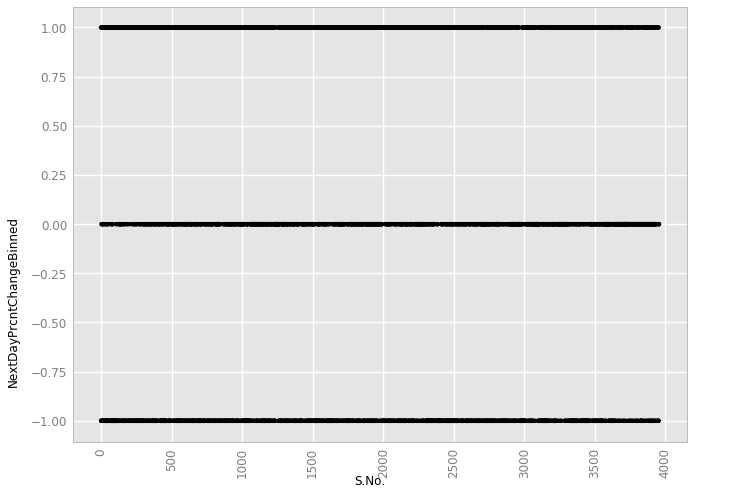

<ggplot: (-9223363252266875178)>

In [5]:
from ggplot import *
p1 = ggplot(aes(x='S.No.', y='NextDayPrcntChangeBinned'), data=NtflxData)
p1 = p1 + geom_point() + theme(axis_text_x = element_text(angle=90))
p1

The following plot shows that all the three target classes are approximately equally represented. This would prevent our model to learn from the features rather than simply predicting the most frequent target class more often.

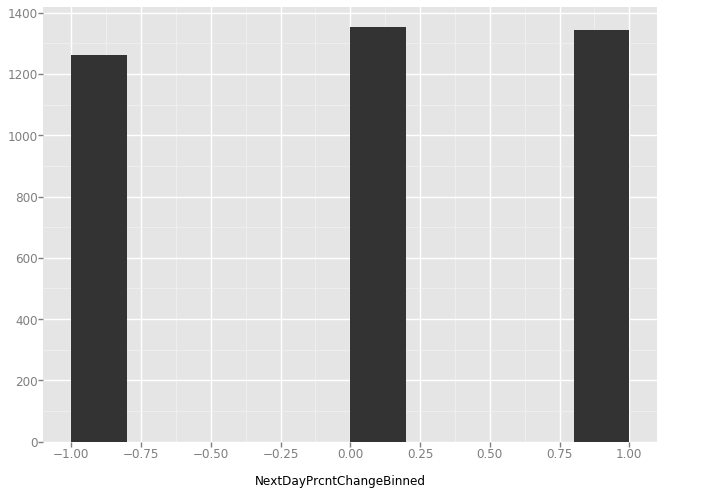

<ggplot: (8784587900585)>

In [6]:
p2 = ggplot(aes('NextDayPrcntChangeBinned'), data=NtflxData)
p2 = p2 + geom_histogram()
p2

Now we'll add *trend* features to know which way the prices/market are heading in the short as well as long term.

We'll start by adding percent change in a given window.

In [7]:
ChangeDays = [1,2,3,5,7,14,30,60,90,120]
for CurrentDay in ChangeDays:
    NewColName = 'PCntChng{0}Days'.format(CurrentDay)
    NtflxData[NewColName] = NtflxData['Close'].pct_change(periods=CurrentDay)
    IVVData[NewColName] = IVVData['Close'].pct_change(periods=CurrentDay)

Adding percent above/below rolling window mean

In [8]:
ChangeDays = [2,3,5,7,14,30,60,90,120]
for CurrentDay in ChangeDays:
    NewColName = 'CloseRolled{0}Day_DiffPer'.format(CurrentDay)
    NtflxData[NewColName] = (NtflxData['Close'] - NtflxData['Close'].rolling(window=CurrentDay).mean()) / NtflxData['Close'].rolling(window=CurrentDay).mean()
    IVVData[NewColName] = (IVVData['Close'] - IVVData['Close'].rolling(window=CurrentDay).mean()) / IVVData['Close'].rolling(window=CurrentDay).mean()

Adding percent above/below rolling Volume mean

In [9]:
ChangeDays = [2,3,5,7,14,30]
for CurrentDay in ChangeDays:
    NewColName = 'VolumeRolled{0}Day_DiffPer'.format(CurrentDay)
    NtflxData[NewColName] = (NtflxData['Volume'] - NtflxData['Volume'].rolling(window=CurrentDay).mean()) / NtflxData['Volume'].rolling(window=CurrentDay).mean()
    IVVData[NewColName] = (IVVData['Volume'] - IVVData['Volume'].rolling(window=CurrentDay).mean()) / IVVData['Volume'].rolling(window=CurrentDay).mean()

In [10]:
display(NtflxData)
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33,-0.049247,-1.0,3952,0.008903,-0.010618,-0.040782,-0.026111,0.023460,0.208832,0.429954,0.336281,0.497788,0.560268,0.004432,-0.000635,-0.021256,-0.020141,0.060785,0.188645,0.285423,0.316823,0.362442,-0.029022,-0.102235,-0.245987,-0.264721,-0.331369,-0.071128
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36,0.045072,1.0,3953,-0.049247,-0.040782,-0.059341,-0.106574,-0.057249,0.147745,0.346573,0.297973,0.417438,0.486901,-0.025245,-0.030479,-0.048328,-0.060806,-0.000721,0.119256,0.216433,0.246866,0.290784,0.131900,0.162913,0.084091,-0.001744,-0.120727,0.189539


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500,139.812500,19,5,2000,4,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600,137.687500,22,5,2000,0,143,-0.006219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409390,NaN,NaN,NaN,NaN,NaN
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900,139.750000,23,5,2000,1,144,-0.015199,-0.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007658,-0.012255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.663835,-0.626100,NaN,NaN,NaN,NaN
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300,138.468750,24,5,2000,2,145,0.014980,-0.000447,-0.006664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007434,0.004793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034100,-0.542479,NaN,NaN,NaN,NaN
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600,137.843750,25,5,2000,3,146,-0.009168,0.005674,-0.009611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004605,-0.001202,-0.005834,NaN,NaN,NaN,NaN,NaN,NaN,-0.703767,-0.752548,-0.899709,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400,267.959991,12,2,2018,0,43,0.013312,0.029119,-0.008940,0.004247,-0.058529,-0.063807,-0.009674,0.029278,0.049534,0.092359,0.006612,0.014004,0.003440,-0.002475,-0.034079,-0.035988,-0.015982,0.000430,0.016435,-0.378359,-0.350970,-0.401763,-0.392786,-0.170687,0.116992
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500,271.649994,13,2,2018,1,44,0.002919,0.016270,0.032124,-0.012166,-0.034483,-0.060581,-0.003310,0.037881,0.051236,0.084858,0.001458,0.006347,0.008870,0.005570,-0.026917,-0.033071,-0.013701,0.002805,0.018725,-0.235282,-0.515897,-0.531829,-0.610980,-0.482368,-0.311683
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400,275.019989,14,2,2018,2,45,0.013771,0.016730,0.030265,0.007641,0.021049,-0.048011,0.002954,0.043443,0.059560,0.103595,0.006838,0.010114,0.021179,0.016366,-0.009999,-0.019850,-0.000812,0.015970,0.031920,0.204883,0.100556,-0.240951,-0.337704,-0.231569,0.055495


Here we'll scale and normalize the appropriate features to prepare them as inputs to our model.

In [11]:
CategoricalFeatures = NtflxData.columns[[8,9,10]]
for CurrentColumn in CategoricalFeatures:
    NtflxData[CurrentColumn] = NtflxData[CurrentColumn].astype('category')
    NtflxData[CurrentColumn] = NtflxData[CurrentColumn].cat.codes
    IVVData[CurrentColumn] = IVVData[CurrentColumn].astype('category')
    IVVData[CurrentColumn] = IVVData[CurrentColumn].cat.codes


### Normalize Volume #####

NtflxData['Volume'] = np.log1p(NtflxData['Volume'])
NtflxData['Volume'] = (NtflxData['Volume'] - np.min(NtflxData['Volume'])) / (np.max(NtflxData['Volume'] - np.min(NtflxData['Volume'])))

IVVData['Volume'] = np.log1p(IVVData['Volume'])
IVVData['Volume'] = (IVVData['Volume'] - np.min(IVVData['Volume'])) / (np.max(IVVData['Volume'] - np.min(IVVData['Volume'])))

display (NtflxData)
display (IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,0.839738,1.210000,23,4,0,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,0.520547,1.157143,24,4,0,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,0.446759,1.103571,28,4,0,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,0.449917,1.071429,29,4,0,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,0.507821,1.076429,30,4,0,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,0.500859,267.429993,1,1,16,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,0.492602,254.259995,2,1,16,4,33,-0.049247,-1.0,3952,0.008903,-0.010618,-0.040782,-0.026111,0.023460,0.208832,0.429954,0.336281,0.497788,0.560268,0.004432,-0.000635,-0.021256,-0.020141,0.060785,0.188645,0.285423,0.316823,0.362442,-0.029022,-0.102235,-0.245987,-0.264721,-0.331369,-0.071128
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,0.530336,265.720001,5,1,16,0,36,0.045072,1.0,3953,-0.049247,-0.040782,-0.059341,-0.106574,-0.057249,0.147745,0.346573,0.297973,0.417438,0.486901,-0.025245,-0.030479,-0.048328,-0.060806,-0.000721,0.119256,0.216433,0.246866,0.290784,0.131900,0.162913,0.084091,-0.001744,-0.120727,0.189539


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,0.550053,139.812500,19,4,0,4,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,0.650107,137.687500,22,4,0,0,143,-0.006219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409390,NaN,NaN,NaN,NaN,NaN
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,0.466132,139.750000,23,4,0,1,144,-0.015199,-0.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007658,-0.012255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.663835,-0.626100,NaN,NaN,NaN,NaN
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,0.473980,138.468750,24,4,0,2,145,0.014980,-0.000447,-0.006664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007434,0.004793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034100,-0.542479,NaN,NaN,NaN,NaN
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,0.272731,137.843750,25,4,0,3,146,-0.009168,0.005674,-0.009611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004605,-0.001202,-0.005834,NaN,NaN,NaN,NaN,NaN,NaN,-0.703767,-0.752548,-0.899709,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,0.799841,267.959991,12,1,18,0,43,0.013312,0.029119,-0.008940,0.004247,-0.058529,-0.063807,-0.009674,0.029278,0.049534,0.092359,0.006612,0.014004,0.003440,-0.002475,-0.034079,-0.035988,-0.015982,0.000430,0.016435,-0.378359,-0.350970,-0.401763,-0.392786,-0.170687,0.116992
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,0.744675,271.649994,13,1,18,1,44,0.002919,0.016270,0.032124,-0.012166,-0.034483,-0.060581,-0.003310,0.037881,0.051236,0.084858,0.001458,0.006347,0.008870,0.005570,-0.026917,-0.033071,-0.013701,0.002805,0.018725,-0.235282,-0.515897,-0.531829,-0.610980,-0.482368,-0.311683
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,0.792490,275.019989,14,1,18,2,45,0.013771,0.016730,0.030265,0.007641,0.021049,-0.048011,0.002954,0.043443,0.059560,0.103595,0.006838,0.010114,0.021179,0.016366,-0.009999,-0.019850,-0.000812,0.015970,0.031920,0.204883,0.100556,-0.240951,-0.337704,-0.231569,0.055495


Now we need to merge the two dataframes, *Netflix* and *S&P500*.

In [12]:
CombinedDF = NtflxData.join(IVVData[['PCntChng1Days','PCntChng2Days','PCntChng3Days','PCntChng5Days','PCntChng7Days','PCntChng14Days','PCntChng30Days','PCntChng60Days','PCntChng90Days','PCntChng120Days','CloseRolled2Day_DiffPer','CloseRolled3Day_DiffPer','CloseRolled5Day_DiffPer','CloseRolled7Day_DiffPer','CloseRolled14Day_DiffPer','CloseRolled30Day_DiffPer']], lsuffix='_Ntflx', rsuffix='_SP500')
display(CombinedDF.shape)
#CombinedDF = CombinedDF.dropna(how='any')
display(CombinedDF.shape)
CombinedDF['NextDayPrcntChangeBinnedCodes'] = pd.Series(CombinedDF['NextDayPrcntChangeBinned'],dtype='category').cat.codes
display(CombinedDF)

(3956, 56)

(3956, 56)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500,NextDayPrcntChangeBinnedCodes
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,0.839738,1.210000,23,4,0,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009995,0.014461,0.003554,-0.001632,-0.000454,0.023321,-0.005328,-0.013348,-0.035721,-0.036648,0.004973,0.008116,0.004066,0.003527,0.014835,0.006844,2
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,0.520547,1.157143,24,4,0,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN,-0.012620,-0.002751,0.001658,-0.019917,-0.006668,0.030220,-0.024051,-0.020623,-0.055169,-0.046722,-0.006350,-0.005153,-0.004595,-0.008195,-0.000072,-0.005050,0
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,0.446759,1.103571,28,4,0,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN,-0.006989,-0.019521,-0.009720,-0.016036,-0.021120,0.027791,-0.024040,-0.050721,-0.042642,-0.047035,-0.003507,-0.008902,-0.008356,-0.012127,-0.008961,-0.011201,0
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,0.449917,1.071429,29,4,0,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN,-0.007316,-0.014253,-0.026693,-0.012619,-0.033886,-0.016514,-0.052669,-0.073226,-0.056919,-0.069202,-0.003671,-0.007224,-0.013128,-0.014512,-0.015049,-0.016646,0
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,0.507821,1.076429,30,4,0,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN,-0.000840,-0.008149,-0.015080,-0.017790,-0.024055,-0.005478,-0.052375,-0.071837,-0.052627,-0.088037,-0.000420,-0.003010,-0.010421,-0.011913,-0.015494,-0.015690,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,0.500859,267.429993,1,1,16,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567,-0.001267,0.000494,-0.010323,-0.005467,-0.005606,0.020497,0.045383,0.090745,0.124500,0.156109,-0.000634,-0.000258,-0.005641,-0.005537,0.000279,0.022662,1
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,0.4

### Build model

Now we are ready to start building our model.

But first, we'll remove *NANs* from the dataframe to prevent difficulties later. Then we'll split the entire data randomly into *Training* and *Testing* set.

In [13]:
CombinedDF = CombinedDF.dropna(how='any')
TrainIndices = np.random.choice(int(len(CombinedDF)), size = round(0.2*int(len(CombinedDF))), replace=False)
TrainIndicesBoolean = pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTest_1 = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
TrainIndicesBoolean = ~pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTrain = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
print ("Our training set:")
display(MyTrain)
print ("Our testing set:")
display(MyTest_1)


Our training set:


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500,NextDayPrcntChangeBinnedCodes
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-12,0.600000,0.614286,0.572143,0.577857,0.577857,0.289746,0.641429,12,10,0,1,316,0.110013,1.0,120,-0.038050,-0.053801,-0.025301,-0.112939,-0.095078,-0.019395,-0.148421,-0.411637,-0.508505,-0.517015,-0.019394,-0.031138,-0.040560,-0.066744,-0.082767,0.009105,-0.191000,-0.279016,-0.335674,0.710383,-0.121773,-0.359447,-0.294455,-0.294500,-0.652521,0.006231,-0.009148,-0.019971,-0.033304,-0.017043,-0.015736,0.035802,-0.069070,-0.093951,-0.193572,0.003106,-0.001012,-0.013550,-0.018130,-0.011684,0.019701,2
2002-11-13,0.579286,0.642857,0.555714,0.641429,0.641429,0.344992,0.618571,13,10,0,2,317,-0.035636,-1.0,121,0.110013,0.067778,0.050294,0.019296,-0.044681,0.107275,0.108644,-0.322264,-0.447384,-0.469893,0.052139,0.057301,0.060714,0.043147,0.011018,0.116037,-0.095563,-0.193895,-0.258550,0.191841,0.673272,0.214609,0.057953,0.021659,-0.470525,-0.002139,0.004078,-0.011267,-0.045347,-0.027540,0.003624,0.066546,-0.059928,-0.071354,-0.185012,-0.001071,0.000640,-0.006368,-0.016331,-0.014048,0.015370,0
2002-11-15,0.642143,0.653571,0.589286,0.650000,0.650000,0.279967,0.778571,15,10,0,4,319,0.197802,1.0,123,0.050809,0.013362,0.124846,0.064328,0.032917,-0.052083,0.387196,-0.339143,-0.487901,-0.411003,0.024775,0.020942,0.052267,0.060077,0.031495,0.112741,-0.068514,-0.169624,-0.241393,0.374412,-0.011502,0.166188,-0.120409,-0.185554,-0.634439,0.007380,0.031931,0.029723,0.020303,-0.014864,0.020873,0.130531,-0.054579,-0.017088,-0.146828,0.003676,0.012921,0.020827,0.019069,0.015368,0.040185,2
2002-11-18,0.648571,0.780714,0.625000,0.778571,0.778571,0.506521,0.664286,18,10,0,0,322,-0.146788,-1.0,124,0.197802,0.258661,0.213807,0.296076,0.313253,0.184782,0.889080,-0.216391,-0.355411,-0.273334,0.090000,0.140963,0.191777,0.217100,0.218752,0.305545,0.121495,0.000724,-0.088744,0.662118,1.315151,1.725239,1.965109,2.259516,0.861065,-0.009840,-0.002533,0.021776,0.025943,-0.000772,0.023161,0.149822,-0.041795,-0.016614,-0.154514,-0.004945,-0.004142,0.005641,0.009154,0.003745,0.025362,0
2002-11-19,0.720000,0.720714,0.623571,0.664286,0.664286,0.653047,0.717143,19,10,0,1,323,0.079570,1.0,125,-0.146788,0.021978,0.073904,0.149568,0.087720,0.035634,0.640212,-0.313653,-0.418750,-0.382880,-0.079207,-0.047781,-0.009373,0.026167,0.037203,0.097993,-0.036103,-0.140295,-0.219367,0.473981,1.098760,2.170497,3.196874,4.639935,3.551015,-0.002319,-0.012136,-0.004846,0.017226,0.007921,0.010739,0.126559,-0.051643,-0.019959,-0.156238,-0.001161,-0.004846,-0.000089,0.005677,0.000657,0.019081,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31,281.940002,282.290009,269.579987,270.2999

Our testing set:


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500,NextDayPrcntChangeBinnedCodes
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-14,0.642857,0.645000,0.618571,0.618571,0.618571,0.168039,0.650000,14,10,0,3,318,0.050809,1.0,122,-0.035636,0.070457,0.029726,0.043373,-0.050440,-0.037778,0.194482,-0.361357,-0.468386,-0.465433,-0.018141,0.009716,0.014289,0.013712,-0.022338,0.070016,-0.120560,-0.216660,-0.281244,-0.552640,-0.560379,-0.600313,-0.693528,-0.663741,-0.839709,0.024371,0.022180,0.028549,0.001765,-0.011863,0.007658,0.104501,-0.051306,-0.015293,-0.159274,0.012039,0.015397,0.017483,0.009387,0.009427,0.036715,2
2002-12-10,0.800000,0.872857,0.799286,0.871429,0.871429,0.345238,0.897143,10,11,0,1,344,0.029508,1.0,139,0.090259,0.114156,0.109092,0.130678,0.124425,0.311828,0.270834,0.016667,0.120295,-0.089552,0.043181,0.065813,0.103474,0.112994,0.125610,0.238789,0.325151,0.186463,0.066558,-0.113837,-0.132132,-0.384386,-0.230981,-0.281876,-0.288710,0.013417,-0.015211,-0.007011,-0.024327,-0.033483,0.003210,0.011720,0.013077,0.047377,-0.101596,0.006664,-0.000735,-0.005813,-0.013066,-0.020728,-0.006790,2
2002-12-19,0.770714,0.799286,0.758571,0.771429,0.771429,0.367352,0.764286,19,11,0,3,353,-0.009259,0.0,146,-0.017288,-0.148936,-0.155589,-0.143536,-0.114754,-0.004608,0.225880,0.053659,-0.001848,-0.249478,-0.008719,-0.060325,-0.096536,-0.109959,-0.064761,0.022179,0.148184,0.040485,-0.047926,-0.559272,-0.397860,-0.153451,-0.110677,-0.106158,-0.230382,-0.008160,-0.019558,-0.027616,-0.022797,-0.021072,-0.053849,-0.044270,0.052426,-0.000338,-0.086200,-0.004097,-0.009304,-0.012531,-0.015736,-0.024884,-0.027087,1
2002-12-24,0.728571,0.732143,0.699286,0.707143,0.707143,0.404081,0.696429,24,11,0,1,358,-0.015151,-1.0,149,-0.034146,-0.074767,-0.083334,-0.219858,-0.208000,-0.004024,0.177171,0.020619,-0.225352,-0.445999,-0.017370,-0.037277,-0.059651,-0.112903,-0.139825,-0.079241,0.052296,-0.040098,-0.113962,0.193108,0.166444,-0.177215,0.022088,0.035732,-0.034440,-0.007102,-0.004229,0.008340,-0.011381,0.001455,-0.032234,0.013595,0.092563,-0.039918,-0.097630,-0.003564,-0.003786,-0.000603,-0.004894,-0.008933,-0.019292,0
2003-01-07,0.771429,0.795714,0.771429,0.783571,0.783571,0.272267,0.815000,7,0,1,1,7,0.040110,1.0,157,-0.011712,0.013863,-0.041922,0.098098,0.125127,-0.142299,-0.002727,0.547247,-0.093389,-0.280656,-0.005891,0.000608,-0.009034,0.023730,0.023252,-0.006491,0.107931,0.088701,0.016634,-0.215642,-0.290135,-0.653446,-0.640666,-0.619541,-0.533944,-0.006017,0.012477,0.014809,0.049699,0.035019,0.013808,-0.017523,0.146771,0.004016,0.019057,-0.003018,0.002094,0.013342,0.024685,0.028321,0.015842,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29,192.509995,193.949997,191

We'll just print out the columns here to visually check their position in the data frame.

In [14]:
pd.set_option("display.max_rows",100)
pd.DataFrame(MyTrain.columns,range(len(MyTrain.columns)))

,0
0,Open
1,High
2,Low
3,Close
4,Adj Close
5,Volume
6,NextDayClose
7,Day
8,Month
9,Year


We'll do a regression of all the possible features and arrange them in the order by which they associate with the target.

In [15]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
FeatureToTest = np.array([7,8,9,10,11])
FeatureToTest = np.append(arr=FeatureToTest, values=np.arange(15,56))
FitOutput = pd.DataFrame(columns=['FeatureName', 'Coeff', 'Abs_Coeff'])
display(FitOutput)
for i in FeatureToTest:
    #reg = linear_model.LinearRegression(fit_intercept=True)
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X = np.reshape(np.array(MyTrain.iloc[:,i]),(-1,1)), y = MyTrain['NextDayPrcntChangeBinned'])
    FitOutput = FitOutput.append(pd.DataFrame({'FeatureName': MyTrain.columns[i], 'Coeff': reg.coef_, 'Abs_Coeff': abs(reg.coef_)}))
FitOutput = FitOutput.sort_values('Abs_Coeff', ascending=False)
display(FitOutput)

,FeatureName,Coeff,Abs_Coeff


,FeatureName,Coeff,Abs_Coeff
0,CloseRolled5Day_DiffPer_SP500,-1.888557,1.888557
0,CloseRolled3Day_DiffPer_SP500,-1.763119,1.763119
0,CloseRolled7Day_DiffPer_SP500,-1.426364,1.426364
0,PCntChng3Days_SP500,-1.296483,1.296483
0,PCntChng2Days_SP500,-1.194732,1.194732
0,CloseRolled14Day_DiffPer_SP500,-1.096675,1.096675
0,CloseRolled2Day_DiffPer_SP500,-0.937740,0.937740
0,PCntChng7Days_SP500,-0.862794,0.862794
0,CloseRolled30Day_DiffPer_SP500,-0.671274,0.671274
0,PCntChng5Days_SP500,-0.551100,0.551100


Now we'll add these features one-by-one in the order that they contribute to the target. This way we can select the best features to combine without including features that may have a negative impact on model tuning.

To do this we'll create k-fold validation sets. We'll then train a model on all folds except the hold-out fold. The model’s performance will be tested on the hold-out fold. This will be repeated until all folds have been used as hold-outs. The prediction statistics will then be averaged across all hold-out folds. First start with creating k-fold validation sets.

,I_index,Accuracy,AccuracyJump
1,0,0.312585,0
1,1,0.312585,0
1,2,0.314868,0.00228279
1,3,0.316170,0.00130187
1,4,0.315843,-0.000326796
1,5,0.318449,0.00260586
1,6,0.318123,-0.000326264
1,7,0.315513,-0.00260958
1,8,0.325287,0.00977358
1,9,0.324959,-0.000327327


,I_index,Accuracy,AccuracyJump
1,31,0.349749,0.0146723
1,19,0.343860,0.00977677
1,8,0.325287,0.00977358
1,42,0.377796,0.00946485
1,35,0.358885,0.00554224
1,27,0.338004,0.00553958
1,15,0.332778,0.00522023
1,40,0.364747,0.0048929
1,34,0.353343,0.00391145
1,41,0.368332,0.00358466


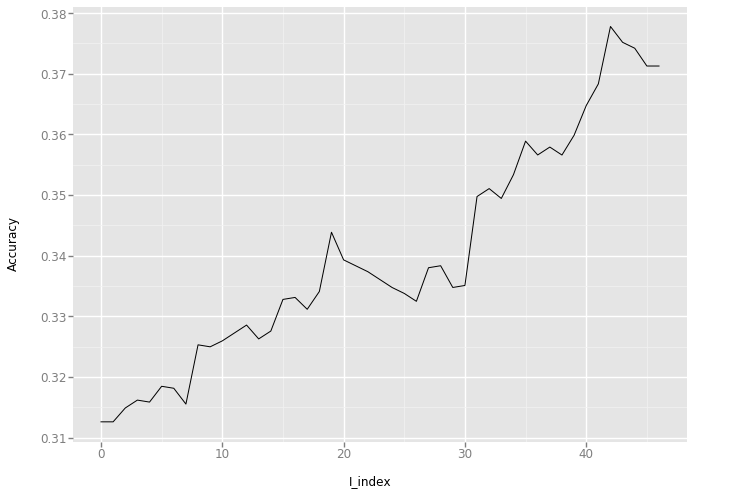

<ggplot: (-9223363252298237436)>

In [16]:
from sklearn.model_selection import KFold
MultiInput_LogReg = pd.DataFrame(columns=['I_index', 'Accuracy', 'AccuracyJump'])
#display(MultiInput_LogReg)
k = 5
kf = KFold(n_splits=k)
kf.get_n_splits(MyTrain)
i = 0
#CurrentR2 = 100
#PreviousR2 = 100
while ((i <= len(FitOutput))):
    #PreviousR2 = CurrentR2
    #i +=1
    CurrentFeatureName = FitOutput['FeatureName'][0:(i+1)]
    CurrentR2Temp = np.empty(k)
    ArrayCounter = 0
    for train_index, test_index in kf.split(MyTrain):
        reg = linear_model.LogisticRegression()
        X_train, X_test = MyTrain.iloc[train_index,:], MyTrain.iloc[test_index,:]
        reg.fit(X = X_train[CurrentFeatureName], y = X_train['NextDayPrcntChangeBinned'])
        ### Now test it ###
        y_true = X_test['NextDayPrcntChangeBinned']
        y_pred = reg.predict(X_test[CurrentFeatureName])
        #CurrentR2Temp[ArrayCounter] = np.sqrt(mean_squared_error(y_true, y_pred))
        CurrentR2Temp[ArrayCounter] = accuracy_score(y_true, y_pred)
        ArrayCounter +=1
    
    CurrentR2 = np.mean(CurrentR2Temp)
    #print("CurrentR2:", CurrentR2)
    #print("CurrentR2Temp:", CurrentR2Temp)
    #print("CurrentFeatureName:", CurrentFeatureName)
    if(i==0):
        AccuracyJump = 0
    else:
        AccuracyJump = (CurrentR2 - MultiInput_LogReg['Accuracy'].iloc[(i-1)])
    
    MultiInput_LogReg = MultiInput_LogReg.append(pd.DataFrame({'I_index': i, 'Accuracy': CurrentR2, 'AccuracyJump': AccuracyJump}, index=np.array([1])))
    i+=1
    #print("i:",i)
    
display(MultiInput_LogReg)
MultiInput_LogReg_Sorted = pd.DataFrame(MultiInput_LogReg, copy=True)
MultiInput_LogReg_Sorted = MultiInput_LogReg_Sorted.sort_values(by=['AccuracyJump'], ascending=False)
display(MultiInput_LogReg_Sorted)
p4 = ggplot(aes(y='Accuracy', x='I_index'), data=MultiInput_LogReg)
p4 = p4 + geom_line()
display(p4)

In [17]:
display(MultiInput_LogReg['Accuracy'].iloc[1])

0.31258508642815014

Adding more features increases the model accuracy. But some features when combined with others result in big jumps in accuracy. These features will specifically be used later to further tune our stacking model.

### Develop *XGBoost* and *SVM* models

We'll now train *XGBoost* and *SVM* models and use them to make out-of-fold predictions. These out-of-fold predictions will then make our level-2 training data for the stacked NN model.

In [18]:
pd.set_option("display.max_rows",10)
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm

FetauresToTake = 47
CurrentFeatureName = FitOutput['FeatureName'][0:FetauresToTake]
Level_1_DF = pd.DataFrame()
k = 5
kf = KFold(n_splits=k)
kf.get_n_splits(MyTrain)
XGBAccuracyArray = np.empty(k)
SVMAccuracyArray = np.empty(k)
i = 0
for train_index, test_index in kf.split(MyTrain):
    #model = XGBClassifier(objective="reg:logistic")
    X_train, X_test = MyTrain.iloc[train_index,:], MyTrain.iloc[test_index,:]
    MyCurrentTrain_X = X_train[CurrentFeatureName]
    MyCurrentTrain_Y = X_train['NextDayPrcntChangeBinnedCodes']
    MyCurrentTest_X = X_test[CurrentFeatureName]
    MyCurrentTest_Y = X_test['NextDayPrcntChangeBinnedCodes']
    #display(X_test)
    
        
    TrainMat = xgb.DMatrix(MyCurrentTrain_X, label=MyCurrentTrain_Y)
    TestMat = xgb.DMatrix(MyCurrentTest_X, label=MyCurrentTest_Y)
    
    Params = {}
    Params['objective'] = 'multi:softmax'
    Params['num_class'] = 3
    Params['eta'] = 0.1
    Params['max_depth'] = 7
    Params['silent'] = 1
    
    NumRound = 51
    #Tracklist = [(TrainMat, 'train'), (TestMat, 'test')]
    XGBModel = xgb.train(Params, TrainMat, NumRound)
    #display(XGBModel)
    XGBPreds = XGBModel.predict(TestMat)
    
    SVMModel = svm.SVC(decision_function_shape='ovo', verbose=False, gamma=0.01)
    SVMModel.fit(X=MyCurrentTrain_X, y=MyCurrentTrain_Y) 
    #display(ModelSVM)
    SVMPreds = SVMModel.predict(MyCurrentTest_X)
    SVMaccuracy_rate = np.sum(SVMPreds == MyCurrentTest_Y) / MyCurrentTest_Y.shape[0]
    
    
    #Level_1_DF = Level_1_DF.append(pd.DataFrame(X_test, Preds))
    
    XGBaccuracy_rate = np.sum(XGBPreds == MyCurrentTest_Y) / MyCurrentTest_Y.shape[0]
    XGBAccuracyArray[i] = XGBaccuracy_rate
    SVMAccuracyArray[i] = SVMaccuracy_rate
    
    Level_1_DF_Temp = pd.concat([X_test, pd.DataFrame(data = {'XGBPredictions': np.reshape(XGBPreds, (-1)), 'SVMPredictions': np.reshape(SVMPreds, (-1))}, index=X_test.index.values)], axis=1, copy=True, sort=False)
    SVMaccuracy_rate = np.sum(Level_1_DF_Temp['SVMPredictions'] == MyCurrentTest_Y) / MyCurrentTest_Y.shape[0]
    XGBaccuracy_rate = np.sum(Level_1_DF_Temp['XGBPredictions'] == MyCurrentTest_Y) / MyCurrentTest_Y.shape[0]
    Level_1_DF = Level_1_DF.append(Level_1_DF_Temp, sort=False)
    #Level_1_DF = Level_1_DF.append(pd.concat([X_test, pd.DataFrame(data = {'XGBPredictions': np.reshape(XGBPreds, (-1)), 'SVMPredictions': np.reshape(SVMPreds, (-1))}, index=X_test.index.values)], axis=1, copy=True, sort=False))
    i+= 1
    print('Accuracy for fold {} using XGB = {}'.format(i, XGBaccuracy_rate))
    print('Accuracy for fold {} using SVM = {}'.format(i, SVMaccuracy_rate))
    print ("############################")
    #display (pd.concat([pd.DataFrame(np.reshape(Preds, (-1,1)), index=X_test.index.values), X_test], axis=1, copy=True))

#########################
display(Level_1_DF)
print('Mean accuracy with softmax for XGB = {}'.format(np.mean(XGBAccuracyArray)))
print('Mean accuracy with softmax for SVM = {}'.format(np.mean(SVMAccuracyArray)))

Accuracy for fold 1 using XGB = 0.3550488599348534
Accuracy for fold 1 using SVM = 0.3306188925081433
############################
Accuracy for fold 2 using XGB = 0.3697068403908795
Accuracy for fold 2 using SVM = 0.32084690553745926
############################
Accuracy for fold 3 using XGB = 0.3534201954397394
Accuracy for fold 3 using SVM = 0.3257328990228013
############################
Accuracy for fold 4 using XGB = 0.3539967373572594
Accuracy for fold 4 using SVM = 0.37846655791190864
############################
Accuracy for fold 5 using XGB = 0.42251223491027734
Accuracy for fold 5 using SVM = 0.36867862969004894
############################


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500,NextDayPrcntChangeBinnedCodes,XGBPredictions,SVMPredictions
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-12,0.600000,0.614286,0.572143,0.577857,0.577857,0.289746,0.641429,12,10,0,1,316,0.110013,1.0,120,-0.038050,-0.053801,-0.025301,-0.112939,-0.095078,-0.019395,-0.148421,-0.411637,-0.508505,-0.517015,-0.019394,-0.031138,-0.040560,-0.066744,-0.082767,0.009105,-0.191000,-0.279016,-0.335674,0.710383,-0.121773,-0.359447,-0.294455,-0.294500,-0.652521,0.006231,-0.009148,-0.019971,-0.033304,-0.017043,-0.015736,0.035802,-0.069070,-0.093951,-0.193572,0.003106,-0.001012,-0.013550,-0.018130,-0.011684,0.019701,2,2.0,0
2002-11-13,0.579286,0.642857,0.555714,0.641429,0.641429,0.344992,0.618571,13,10,0,2,317,-0.035636,-1.0,121,0.110013,0.067778,0.050294,0.019296,-0.044681,0.107275,0.108644,-0.322264,-0.447384,-0.469893,0.052139,0.057301,0.060714,0.043147,0.011018,0.116037,-0.095563,-0.193895,-0.258550,0.191841,0.673272,0.214609,0.057953,0.021659,-0.470525,-0.002139,0.004078,-0.011267,-0.045347,-0.027540,0.003624,0.066546,-0.059928,-0.071354,-0.185012,-0.001071,0.000640,-0.006368,-0.016331,-0.014048,0.015370,0,0.0,0
2002-11-15,0.642143,0.653571,0.589286,0.650000,0.650000,0.279967,0.778571,15,10,0,4,319,0.197802,1.0,123,0.050809,0.013362,0.124846,0.064328,0.032917,-0.052083,0.387196,-0.339143,-0.487901,-0.411003,0.024775,0.020942,0.052267,0.060077,0.031495,0.112741,-0.068514,-0.169624,-0.241393,0.374412,-0.011502,0.166188,-0.120409,-0.185554,-0.634439,0.007380,0.031931,0.029723,0.020303,-0.014864,0.020873,0.130531,-0.054579,-0.017088,-0.146828,0.003676,0.012921,0.020827,0.019069,0.015368,0.040185,2,0.0,0
2002-11-18,0.648571,0.780714,0.625000,0.778571,0.778571,0.506521,0.664286,18,10,0,0,322,-0.146788,-1.0,124,0.197802,0.258661,0.213807,0.296076,0.313253,0.184782,0.889080,-0.216391,-0.355411,-0.273334,0.090000,0.140963,0.191777,0.217100,0.218752,0.305545,0.121495,0.000724,-0.088744,0.662118,1.315151,1.725239,1.965109,2.259516,0.861065,-0.009840,-0.002533,0.021776,0.025943,-0.000772,0.023161,0.149822,-0.041795,-0.016614,-0.154514,-0.004945,-0.004142,0.005641,0.009154,0.003745,0.025362,0,2.0,1
2002-11-19,0.720000,0.720714,0.623571,0.664286,0.664286,0.653047,0.717143,19,10,0,1,323,0.079570,1.0,125,-0.146788,0.021978,0.073904,0.149568,0.087720,0.035634,0.640212,-0.313653,-0.418750,-0.382880,-0.079207,-0.047781,-0.009373,0.026167,0.037203,0.097993,-0.036103,-0.140295,-0.219367,0.473981,1.098760,2.170497,3.196874,4.639935,3.551015,-0.002319,-0.012136,-0.004846,0.017226,0.007921,0.010739,0.126559,-0.051643,-0.019959,-0.156238,-0.001161,-0.004846,-0.000089,0.005677,0.000657,0.019081,2,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Mean accuracy with softmax for XGB = 0.3709369736066018
Mean accuracy with softmax for SVM = 0.3448687769340723


We'll now prepare inputs for the neural network model that we'll use as the level-2 stacking model.

Just for comparative analysis, we'll also create another NN model on the same level-2 training data, but without predictions from the level-1 models. This will illustrate if the gains in predictive power are not just due to the level-2 model alone.

In [19]:
Year_OneHotCodes = pd.get_dummies(Level_1_DF['Year'])
Month_OneHotCodes = pd.get_dummies(Level_1_DF['Month'])
XGBPred_OneHotCodes = pd.get_dummies(Level_1_DF['XGBPredictions'])
SVMPred_OneHotCodes = pd.get_dummies(Level_1_DF['SVMPredictions'])
FeatureIndex = np.array([0,1])
FeatureIndex = np.append(arr=FeatureIndex, values = MultiInput_LogReg_Sorted['I_index'][0:3])
display(FeatureIndex)
#FeatureIndex = [0,1,9,32,43]
#FeatureIndex = [0,1,11,24,30]
ModelInputs = pd.concat([Level_1_DF[CurrentFeatureName.iloc[FeatureIndex]], XGBPred_OneHotCodes, SVMPred_OneHotCodes], axis=1, sort=False, copy=True)
ModelInputs_NN_NoStack = pd.concat([Level_1_DF[CurrentFeatureName.iloc[FeatureIndex]]], axis=1, sort=False, copy=True)
display(ModelInputs.shape)
ModelOutputs = pd.get_dummies(Level_1_DF['NextDayPrcntChangeBinnedCodes'])
display(ModelOutputs.shape)

array([0, 1, 31, 19, 8], dtype=object)

(3068, 11)

(3068, 3)

Now we'll use *Keras* to make the models.

In [26]:
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Reshape
from keras.models import Model, load_model
from keras import metrics, initializers, optimizers, regularizers

BatchSize = 1
allInputs = Input(shape=(ModelInputs.shape[1],), dtype='float32', name='all_input')

NN = Dense(ModelInputs.shape[1], activation='relu', kernel_initializer=initializers.TruncatedNormal(seed=50))(allInputs)
NN = Dropout(0.15)(NN)
NN = Dense(ModelInputs.shape[1], activation='relu', kernel_initializer=initializers.TruncatedNormal(seed=50))(NN)
NN = Dropout(0.15)(NN)
main_output = Dense(3, name='main_output', activation = 'softmax', kernel_initializer=initializers.TruncatedNormal(seed=50))(NN)

NNModel = Model(inputs=[allInputs], outputs = [main_output])


display(NNModel.summary())

print ("##############")

nostckInputs = Input(shape=(ModelInputs_NN_NoStack.shape[1],), dtype='float32', name='allNOStack_input')
NN_NoStack = Dense(ModelInputs.shape[1], activation='relu', kernel_initializer=initializers.TruncatedNormal(seed=50))(nostckInputs)

NN_NoStack = Dropout(0.15)(NN_NoStack)
NN_NoStack = Dense(ModelInputs.shape[1], activation='relu', kernel_initializer=initializers.TruncatedNormal(seed=50))(NN_NoStack)
NN_NoStack = Dropout(0.15)(NN_NoStack)

main_output = Dense(3, name='main_output', activation = 'softmax', kernel_initializer=initializers.TruncatedNormal(seed=50))(NN_NoStack)


NN_NoStack_Model = Model(inputs=[nostckInputs], outputs = [main_output])


display(NN_NoStack_Model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
all_input (InputLayer)       (None, 11)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_9 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 11)                132       
_________________________________________________________________
dropout_10 (Dropout)         (None, 11)                0         
_________________________________________________________________
main_output (Dense)          (None, 3)                 36        
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________


None

##############
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
allNOStack_input (InputLayer (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 11)                66        
_________________________________________________________________
dropout_11 (Dropout)         (None, 11)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 11)                132       
_________________________________________________________________
dropout_12 (Dropout)         (None, 11)                0         
_________________________________________________________________
main_output (Dense)          (None, 3)                 36        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_______________________________________________________________

None

Now we'll train the two NN models.

In [27]:
BSize = 1
MyLR = (BSize/len(Level_1_DF))
Myadadelta = optimizers.adadelta(lr=MyLR, decay = MyLR/10)
NNModel.compile(optimizer=Myadadelta,
              loss={'main_output': 'categorical_crossentropy'}, metrics=['categorical_accuracy'])

history = NNModel.fit({'all_input': ModelInputs, 'year_input': Level_1_DF['Year']},
          {'main_output': ModelOutputs},
         epochs=10, batch_size=BSize, verbose=1, validation_split=0.25, shuffle = True)

print ("###################")

NN_NoStack_Model.compile(optimizer=Myadadelta,
              loss={'main_output': 'categorical_crossentropy'}, metrics=['categorical_accuracy'])

history = NN_NoStack_Model.fit({'allNOStack_input': ModelInputs_NN_NoStack, 'year_input': Level_1_DF['Year']},
          {'main_output': ModelOutputs},
         epochs=10, batch_size=BSize, verbose=1, validation_split=0.25, shuffle = True)


Train on 2301 samples, validate on 767 samples
Epoch 1/10
2301/2301 [==============================] - 4s 2ms/step - loss: 1.0986 - categorical_accuracy: 0.3512 - val_loss: 1.0987 - val_categorical_accuracy: 0.2947
Epoch 2/10
2301/2301 [==============================] - 3s 1ms/step - loss: 1.0986 - categorical_accuracy: 0.3468 - val_loss: 1.0988 - val_categorical_accuracy: 0.2947
Epoch 3/10
2301/2301 [==============================] - 3s 1ms/step - loss: 1.0986 - categorical_accuracy: 0.3455 - val_loss: 1.0988 - val_categorical_accuracy: 0.2947
Epoch 4/10
2301/2301 [==============================] - 3s 1ms/step - loss: 1.0986 - categorical_accuracy: 0.3529 - val_loss: 1.0988 - val_categorical_accuracy: 0.2947
Epoch 5/10
2301/2301 [==============================] - 3s 1ms/step - loss: 1.0986 - categorical_accuracy: 0.3416 - val_loss: 1.0988 - val_categorical_accuracy: 0.2947
Epoch 6/10
2301/2301 [==============================] - 3s 1ms/step - loss: 1.0986 - categorical_accuracy: 0.3429

Now we'll make predictions on the test set. Just to see if out stacked model actually performs better or worse than the other models, we'll use them as well to predict targets in the test set.

In [28]:
MyTest_1_X = MyTest_1[CurrentFeatureName]
MyTest_1_Y = MyTest_1['NextDayPrcntChangeBinnedCodes']
TestMat_1 = xgb.DMatrix(MyTest_1_X, label=MyTest_1_Y)

XGB_MyTest_1_Preds = XGBModel.predict(TestMat_1)
SVM_MyTest_1_Preds = SVMModel.predict(MyTest_1[CurrentFeatureName])

Level_2_DF = pd.DataFrame(MyTest_1, copy=True)
Level_2_DF['XGBoostPreds'] = XGB_MyTest_1_Preds
Level_2_DF['SVMPreds'] = SVM_MyTest_1_Preds

XGBPred_2_OneHotCodes = pd.get_dummies(Level_2_DF['XGBoostPreds'])
SVMPred_2_OneHotCodes = pd.get_dummies(Level_2_DF['SVMPreds'])
Predict_2_Inputs = pd.concat([Level_2_DF[CurrentFeatureName.iloc[FeatureIndex]], XGBPred_2_OneHotCodes, SVMPred_2_OneHotCodes], axis=1, sort=False)
Predict_2_NoStackInputs = pd.concat([Level_2_DF[CurrentFeatureName.iloc[FeatureIndex]]], axis=1, sort=False)

MyTest_1_NNPreds = NNModel.predict({'all_input': Predict_2_Inputs}, batch_size=1)
MyTest_1_NNNoStackPreds = NN_NoStack_Model.predict({'allNOStack_input': Predict_2_NoStackInputs}, batch_size=1)


MyTest_1_NNPreds_Ys = np.argmax(MyTest_1_NNPreds, axis=1)
MyTest_1_NNNoStackPreds_Ys = np.argmax(MyTest_1_NNNoStackPreds, axis=1)

Stacked_accuracy_rate = np.sum(MyTest_1_NNPreds_Ys == MyTest_1_Y) / MyTest_1_Y.shape[0]
NoStack_accuracy_rate = np.sum(MyTest_1_NNNoStackPreds_Ys == MyTest_1_Y) / MyTest_1_Y.shape[0]
XGBLevel_2_accuracy_rate = np.sum(XGB_MyTest_1_Preds == MyTest_1_Y) / MyTest_1_Y.shape[0]
SVMLevel_2_accuracy_rate = np.sum(SVM_MyTest_1_Preds == MyTest_1_Y) / MyTest_1_Y.shape[0]
print('Accuracy of stacked model = {}'.format(Stacked_accuracy_rate))
print('Accuracy of NN No-stack model = {}'.format(NoStack_accuracy_rate))
print('Accuracy of XGB model = {}'.format(XGBLevel_2_accuracy_rate))
print('Accuracy of SVM model = {}'.format(SVMLevel_2_accuracy_rate))


Accuracy of stacked model = 0.36897001303780963
Accuracy of NN No-stack model = 0.36766623207301175
Accuracy of XGB model = 0.3428943937418514
Accuracy of SVM model = 0.3546284224250326


Looks like our stacked model has a better accuracy on the test data than the original models.